In [1]:
import scipy.io
import scipy.signal
import os 
import pandas as pd
import zipfile
import requests
import xlrd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import statistics as stats
from math import isclose
from sklearn import mixture

%matplotlib inline

In [2]:
data1 = pd.read_excel("data/CS2_33/CS2_33_10_04_10.xlsx", sheet_name= "Channel_1-006")
#it looks like all of these have the sheet name channel_1-006, not just this specific excel file? 
#would be nice to create a function to iterate over all the files in a given file and import them, store them in variable. 

In [3]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [4]:
data1['dQ/dV'] = data1['Discharge_Capacity(Ah)']/data1['dV']
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=['dQ/dV'])
data1 = data1.reset_index(drop = True)


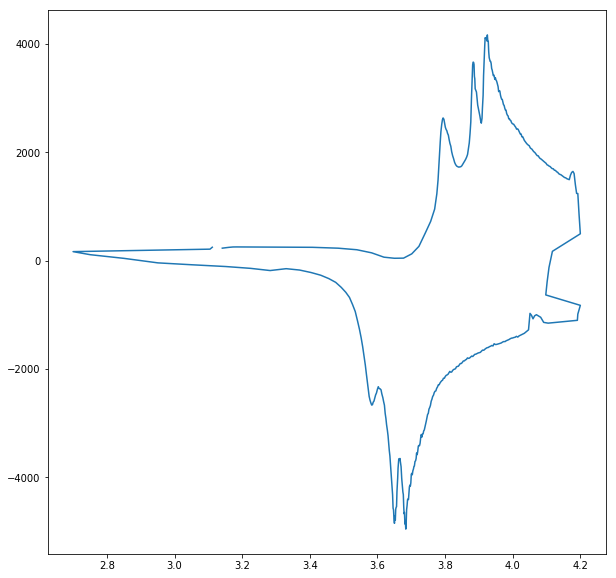

In [7]:
for i in range(1,len(data1)):
    if isclose(data1.loc[i, ('dV')], 0, abs_tol = 10**-3):
        data1 = data1.drop(index = i)
#drop rows if dv is about 0, this will clean up the data points around V = 4.2V (since they are holding it at 4.2V for a while)
#have to recalculate the dv after this I think 

data1 = data1.reset_index(drop = True)

#recalculating dv after dropping rows
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]
data1['dQ/dV'] = data1['Discharge_Capacity(Ah)']/data1['dV']
    
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=["dQ/dV"])
unfilt = pd.concat([data1['dQ/dV']])
unfiltar = unfilt.values
data1['filtered dq/dv'] = scipy.signal.savgol_filter(unfiltar, 19, 3)


df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 6:
        df1 = df1.append(data1.loc[i])
                
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['filtered dq/dv'])

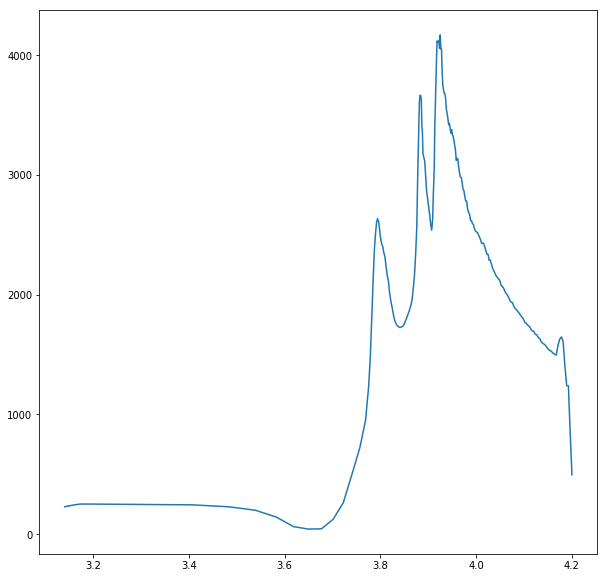

In [8]:
dftop = pd.DataFrame()
dftop = df1[df1['filtered dq/dv'] > 0].head(len(dftop.index)-6)
dftop = dftop.reset_index(drop=True)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(dftop['Voltage(V)'], dftop['filtered dq/dv'])

## LMFit

In [9]:
#!/usr/bin/env python
#<examples/doc_model1.py>
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model

import matplotlib.pyplot as plt

data = loadtxt('model1d_gauss.dat')
x = data[:, 0]
y = data[:, 1]

def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(sqrt(2*pi)*wid)) * exp(-(x-cen)**2 /(2*wid**2))

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=5, cen=5, wid=1)

print(result.fit_report())

plt.plot(x, y,         'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')

OSError: model1d_gauss.dat not found.

[[Model]]
    (Model(step, prefix='step_', form='erf') + Model(linear, prefix='line_'))
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 201
    # variables        = 5
    chi-square         = 596.013
    reduced chi-square = 3.041
    Akaike info crit   = 228.479
    Bayesian info crit = 244.995
[[Variables]]
    line_intercept:   11.8724495 +/- 0.277481 (2.34%) (init= 11.64818)
    line_slope:       1.92948960 +/- 0.093649 (4.85%) (init= 0)
    step_sigma:       0.68432645 +/- 0.011067 (1.62%) (init= 1.428571)
    step_center:      3.12858264 +/- 0.005237 (0.17%) (init= 2.5)
    step_amplitude:   112.706752 +/- 0.658880 (0.58%) (init= 134.2703)
[[Correlations]] (unreported correlations are <  0.100)
    C(line_slope, step_amplitude)  = -0.879 
    C(step_sigma, step_amplitude)  =  0.568 
    C(line_slope, step_sigma)    = -0.460 
    C(line_intercept, step_center)  =  0.430 
    C(line_intercept, line_slope)  = -0.304 
    C(line_slope, step_center)   = -0.236 

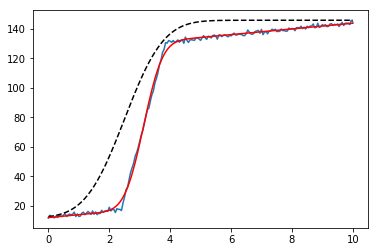

In [2]:
from lmfit.models import StepModel, LinearModel

import matplotlib.pyplot as plt

x = np.linspace(0, 10, 201)
y = np.ones_like(x)
y[:48] = 0.0
y[48:77] = np.arange(77-48)/(77.0-48)
y = 110.2 * (y + 9e-3*np.random.randn(len(x))) + 12.0 + 2.22*x

step_mod = StepModel(form='erf', prefix='step_')
line_mod = LinearModel(prefix='line_')

pars =  line_mod.make_params(intercept=y.min(), slope=0)
pars += step_mod.guess(y, x=x, center=2.5)

mod = step_mod + line_mod
out = mod.fit(y, pars, x=x)

print(out.fit_report())

plt.plot(x, y)
plt.plot(x, out.init_fit, 'k--')
plt.plot(x, out.best_fit, 'r-')